In [45]:
import hazel
#import sunpy.map as smap
from sunpy.net import Fido, attrs as a
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from astropy.io import fits
import imageio as io
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import pandas as pd
import glob
import math

# Index

1. Functions

2. Map setting

3. Inversion

4. Comparison VFIVS inversion and Hazel v2 inversion

5. Save the inversions

# 1. Functions

In [85]:
def Bfield_Bz (output,sg):
    f = h5py.File(dir_outputs+output, 'r')
    t = 22
    ph1 = f['ph1']
    ny = int(np.sqrt(ph1['Bx'][:,:,t].shape[0]))
    nx = math.ceil(np.sqrt(ph1['Bx'][:,:,t].shape[0]))
    Bx = np.squeeze(ph1['Bx'][:,:,t]).reshape((nx,ny))
    By = np.squeeze(ph1['By'][:,:,t]).reshape((nx,ny))
    Bz = np.squeeze(ph1['Bz'][:,:,t]).reshape((nx,ny))
    f.close()
    Br = np.sqrt(Bx**2 + By**2 + Bz**2)
    Br_g = gaussian_filter(Br, sigma=sg)

    return (Bz,Br,Br_g)

def two_plots (plot1,plot2,title1,title2,sunspot_date,sunspot_date1,display_max_mins):
    
    hduf_field = fits.open('/home/miguel/Solar-physics-project/Thesis/magnetograms/B_submpas_'+sunspot_date1+'/submap.hmi.b_720s.'+sunspot_date+'_TAI.field.fits')
    hduf_magnetogram = fits.open('/home/miguel/Solar-physics-project/Thesis/magnetograms/submpas_magnetogram_'+sunspot_date1+'/submap.hmi.m_720s.'+sunspot_date+'_TAI.1.magnetogram.fits')
    
    field = np.asarray(hduf_field[0].data)
    magnetogram = np.asarray(hduf_magnetogram[0].data)
    if (display_max_mins == True):
        print('Magnetic field magnitude minimum value: ',np.min(field), '[G]')
        print('Magnetic field magnitude maximum value: ',np.max(field), '[G]')
        print(' ')
        print('Magnetogram minimum value: ',np.min(magnetogram), '[G]')
        print('Magnetogram maximum value: ',np.max(magnetogram), '[G]\n')
    
    fig = plt.figure(figsize=(17,7))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    im1 = ax1.imshow(plot1,origin='lower',cmap='nipy_spectral',vmin=np.min(field),vmax=np.max(field))
    ax1.set_title(title1, fontsize = 25)
    ax1.set_xlabel('x-direction [pixel]')
    ax1.set_ylabel('y-direction [pixel]')
    im2 = ax2.imshow(plot2,origin='lower',cmap='seismic',vmin=np.min(magnetogram),vmax=np.max(magnetogram))
#ax2.set_title('HMI 2011-10-27 Inverted with the HMI pipeline',fontsize=20)
    ax2.set_title(title2, fontsize = 25)
    ax2.set_xlabel('x-direction [pixel]')
    ax2.set_ylabel('y-direction [pixel]')

    fig.colorbar(im1,ax=ax1)
    fig.colorbar(im2,ax=ax2)
    plt.tight_layout()

# 2. Map setting

In [75]:
#set directories
dir_outputs = '/home/miguel/Solar-physics-project/Thesis/inversions/outputs/'
dir_magnetogram = '/home/miguel/Solar-physics-project/Thesis/magnetograms/'
#set sunspot date
sunspot_date = '20121117_010000'
sunspot_date1 = '2012-11-17T01:04:00'
Branges = '_BxyxR3500'
Bnodes = '_Bxyz221'
StokesW = '_IQUV1553.5'

hduf_field = fits.open('/home/miguel/Solar-physics-project/Thesis/magnetograms/B_submpas_'+sunspot_date1+'/submap.hmi.b_720s.'+sunspot_date+'_TAI.field.fits')
hduf_magnetogram = fits.open('/home/miguel/Solar-physics-project/Thesis/magnetograms/submpas_magnetogram_'+sunspot_date1+'/submap.hmi.m_720s.'+sunspot_date+'_TAI.1.magnetogram.fits')

#save VFISV field data
field = np.asarray(hduf_field[0].data)
magnetogram = np.asarray(hduf_magnetogram[0].data)

#save VFISV magnetogram data
atm_glob = glob.glob(dir_outputs+'output_3d_atm_r0_cm_*.h5')


# 3. Inversion

In [30]:
!/home/miguel/miniconda3/envs/hazel_env/bin/mpiexec -n 12 python '/home/miguel/Solar-physics-project/Thesis/inversions/inversion_mpi.py'


2024-02-09 21:03:23,882 - Hazel2 v1.0
2024-02-09 21:03:23,882 - Using configuration from file : /home/miguel/Solar-physics-project/Thesis/inversions/conf_hmi_3d.ini
2024-02-09 21:03:23,883 - Backtracking mode : brent
2024-02-09 21:03:23,883 - Adding spectral region spec1
2024-02-09 21:03:23,884 -   - Using wavelength axis from 6173.15 to 6173.55 with 150 steps
2024-02-09 21:03:23,884 -   - Reading wavelength axis from /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.wavelength
2024-02-09 21:03:23,884 -   - Reading wavelength weights from /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi_5_1_1_1.weights
2024-02-09 21:03:23,884 -   - Using observations from /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_20111027_113600_159x160.h5
2024-02-09 21:03:23,884 -   - No mask for pixels
2024-02-09 21:03:23,884 -   - No instrumental profile
2024-02-09 21:03:23,884 -   - Using LOS ['0.0', '0.0', '90.0']
2024-02-09 21:03:23,8

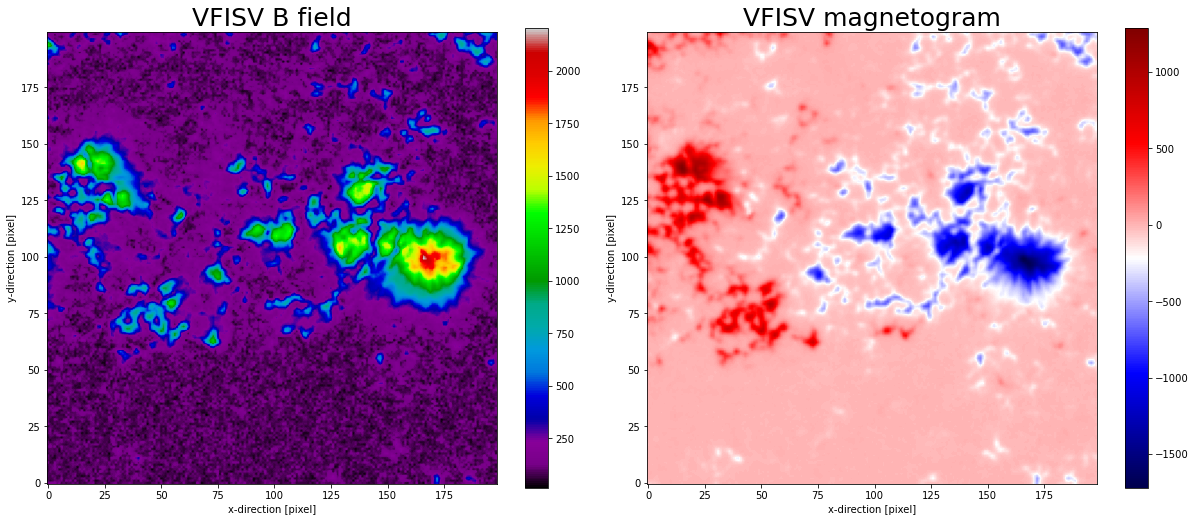

In [72]:
two_plots(field,magnetogram,'VFISV B field','VFISV magnetogram',sunspot_date,sunspot_date1,display_max_mins=False) #output_3d_20121116_230000_BxyxR2000_Bxyz221_IQUV1553.5.h5

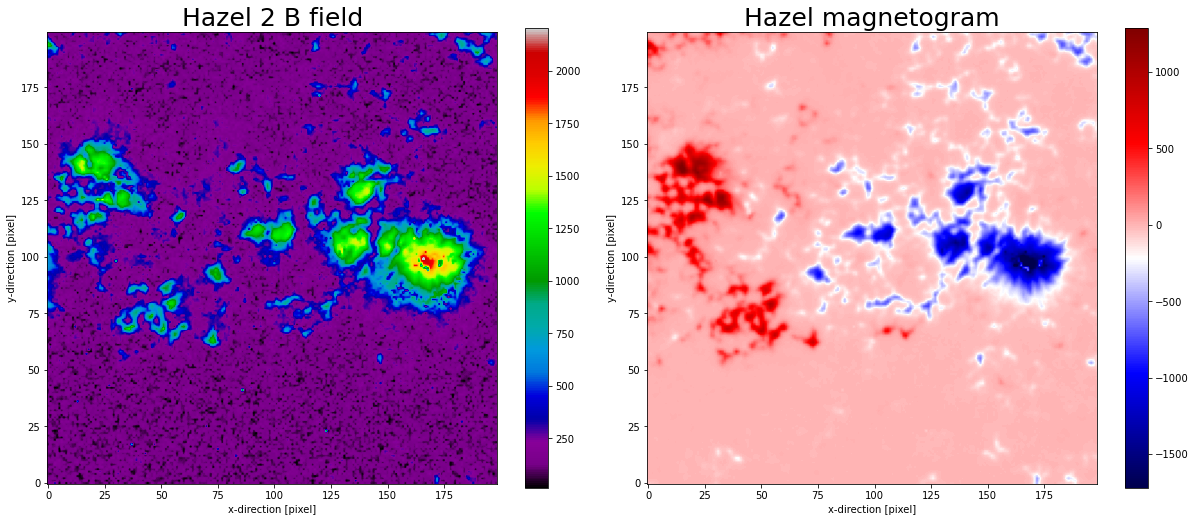

In [86]:
maps_hazel = Bfield_Bz('output_3d_'+sunspot_date+Branges+Bnodes+StokesW+'.h5',0.0)
two_plots(maps_hazel[2],maps_hazel[0],'Hazel 2 B field','Hazel magnetogram',sunspot_date,sunspot_date1,display_max_mins=False)

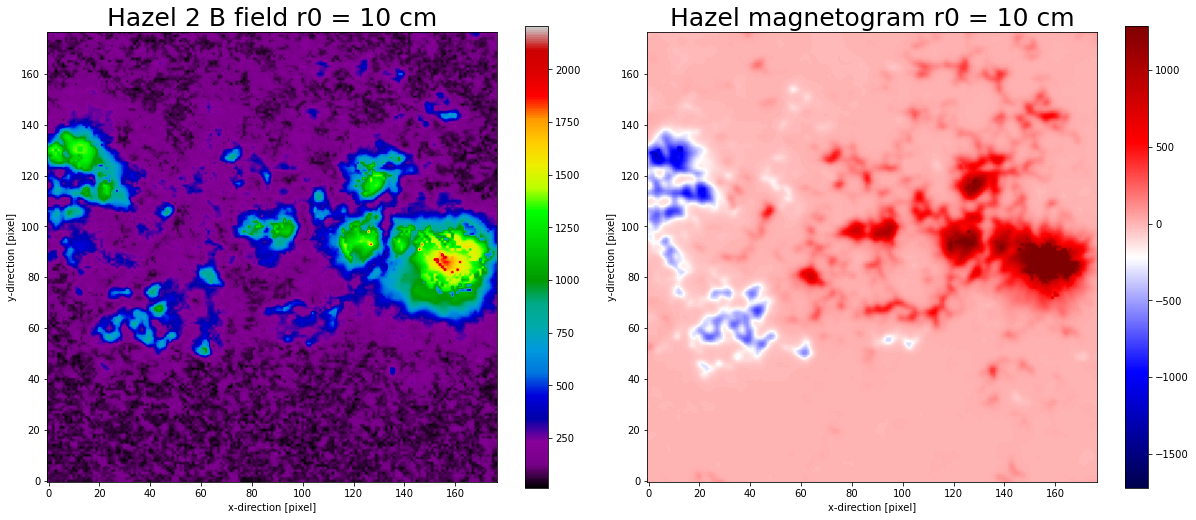

In [87]:
maps_hazel_r10 = Bfield_Bz('output_3d_atm_r0_cm_10.0_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r10[2],maps_hazel_r10[0],'Hazel 2 B field r0 = 10 cm','Hazel magnetogram r0 = 10 cm','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)

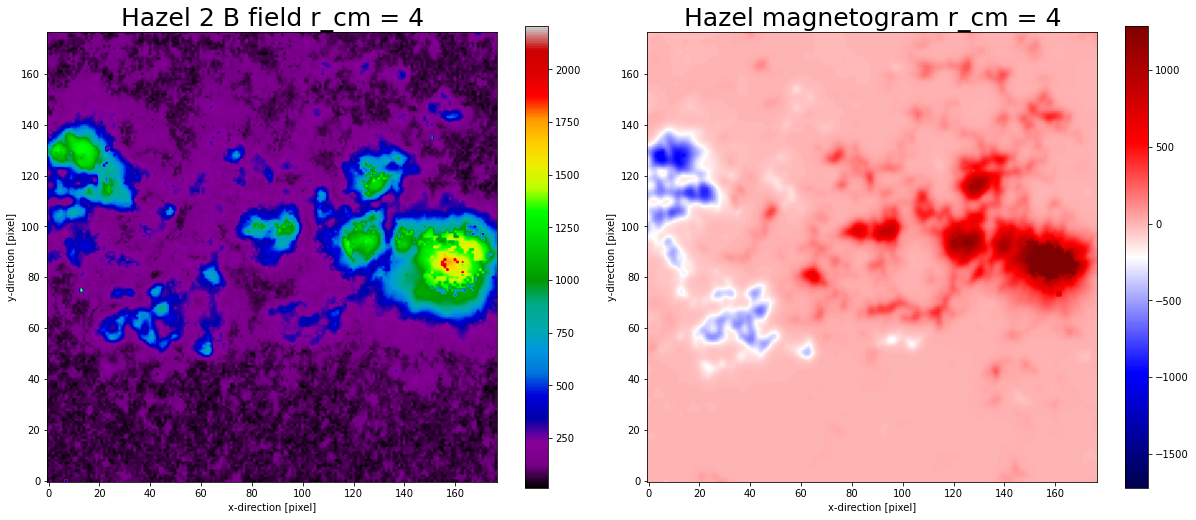

In [88]:
maps_hazel_r4 = Bfield_Bz('output_3d_atm_r0_cm_4.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r4[2],maps_hazel_r4[0],'Hazel 2 B field r_cm = 4','Hazel magnetogram r_cm = 4','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)

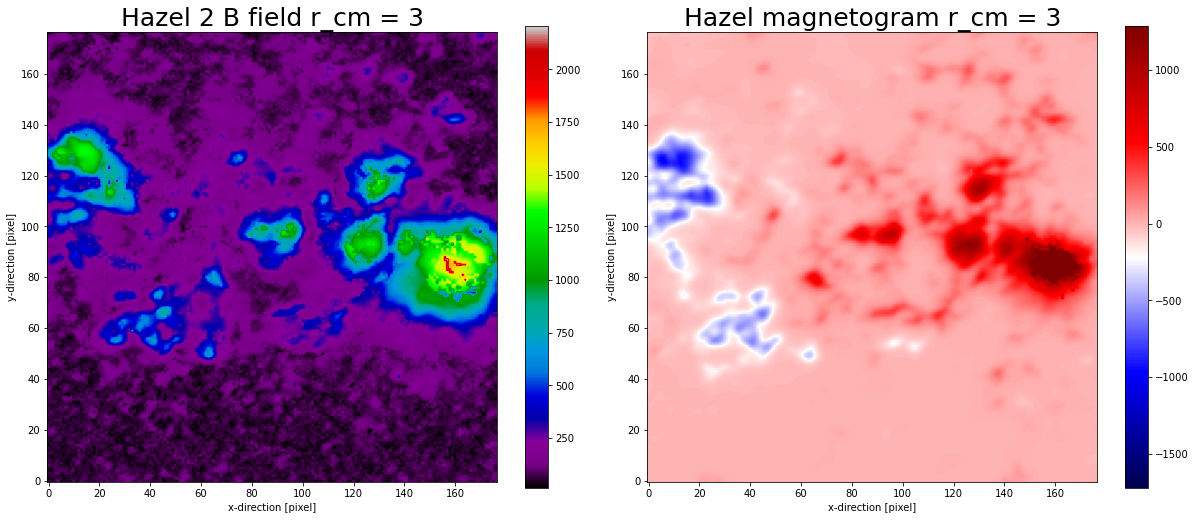

In [89]:
maps_hazel_r3 = Bfield_Bz('output_3d_atm_r0_cm_3.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r3[2],maps_hazel_r3[0],'Hazel 2 B field r_cm = 3','Hazel magnetogram r_cm = 3','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)

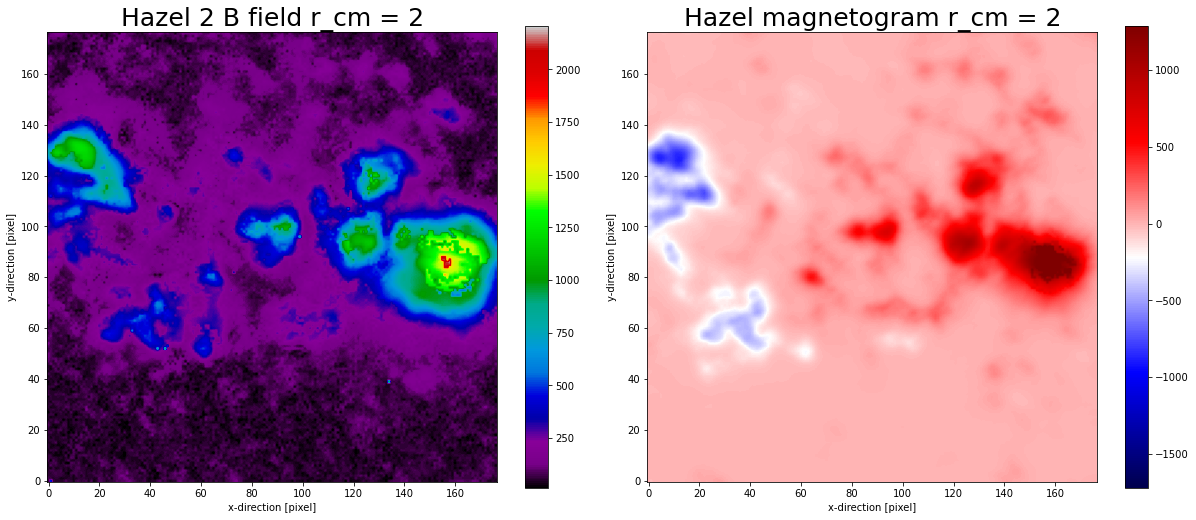

In [90]:
maps_hazel_r2 = Bfield_Bz('output_3d_atm_r0_cm_2.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r2[2],maps_hazel_r2[0],'Hazel 2 B field r_cm = 2','Hazel magnetogram r_cm = 2','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)

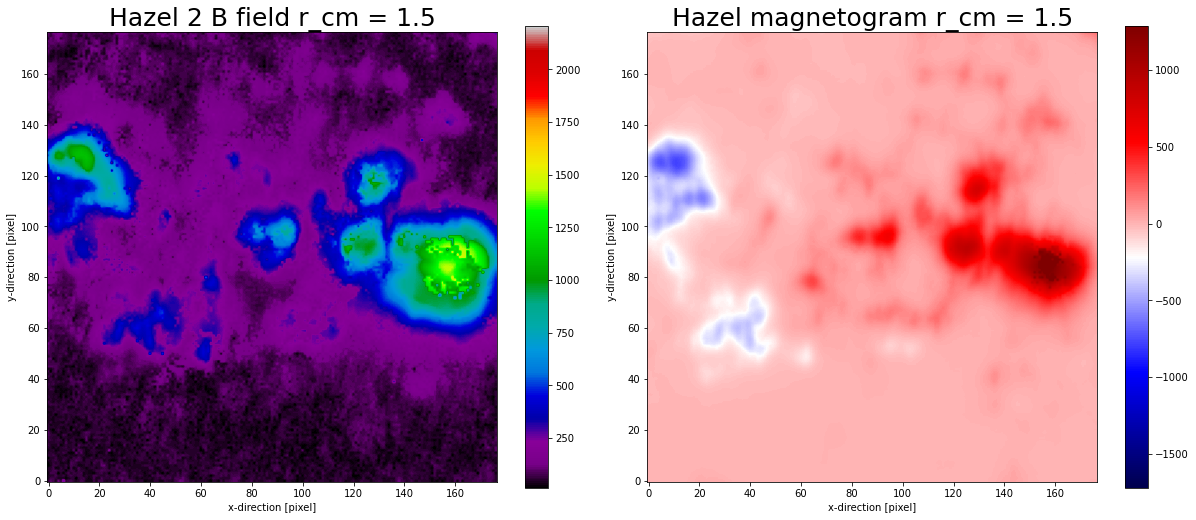

In [91]:
maps_hazel_r1_5 = Bfield_Bz('output_3d_atm_r0_cm_1.5_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r1_5[2],maps_hazel_r1_5[0],'Hazel 2 B field r_cm = 1.5','Hazel magnetogram r_cm = 1.5','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)

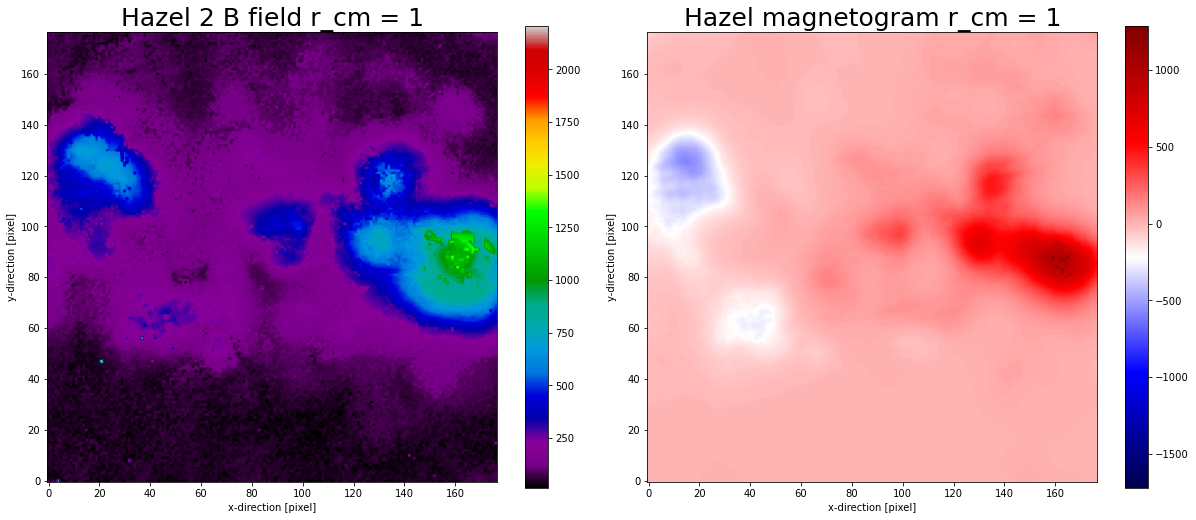

In [92]:
maps_hazel_r1 = Bfield_Bz('output_3d_atm_r0_cm_1.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5',0.0)
two_plots(maps_hazel_r1[2],maps_hazel_r1[0],'Hazel 2 B field r_cm = 1','Hazel magnetogram r_cm = 1','20121117_010000','2012-11-17T01:04:00',display_max_mins=False)